In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

# drug prescription in australia

from the [book](https://www.manning.com/books/time-series-forecasting-in-python-book):

> The objective of the project in this chapter is forecasting the number of antidiabetic drug prescriptions in Australia, from 1991 to 2008. In a professional setting, solving this problem would allow us to gauge the production of antidiabetic drugs, such as to produce enough to meet the demand and but also avoid overproduction

So now that we know our objective, let us get the data and plot it to have an idea of how the time series looks.

In [3]:
df = pd.read_csv('aus_antidiabetic_drug.csv')

In [4]:
df.tail(13)

,ds,y
191,2007-06-01,20.681002
192,2007-07-01,21.834890
193,2007-08-01,23.930204
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945


It seems that we have data from July 1991 to June 2008, before ploting it, I want to check for `nan` values, to be sure we have a complete dataset. Also from 1991 to 2008, there are `12 * 17` weeks, and if we make the math we get `204` which is exactly our data points

In [5]:
df.isnull().values.any()

False

No null values, we can be happy then. Let's plot this

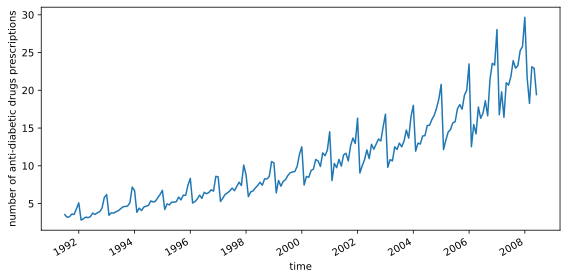

In [6]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(df.y)

ax.set_ylabel('number of anti-diabetic drugs prescriptions')
ax.set_xlabel('time')

ax.set_xticks(
    range(6, 205, 24),
    range(1992, 2009, 2),
)

fig.autofmt_xdate()
plt.tight_layout()

So at a first glance it completely looks like it has trend and seasonality. Let's draw a black line of each year to make this more clear.

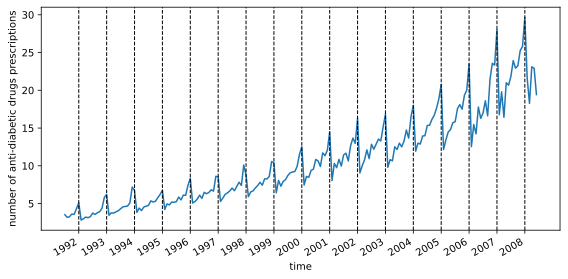

In [7]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(df.y)

ax.set_ylabel('number of anti-diabetic drugs prescriptions')
ax.set_xlabel('time')

ax.set_xticks(
    range(6, 205, 12),
    range(1992, 2009, 1),
)


# draw line every year
for i in np.arange(6, 205, 12):
    ax.axvline(x = i, linestyle = '--', color = 'black', linewidth = 1)

fig.autofmt_xdate()
plt.tight_layout()


It seems that exactly at the eand of every year the prescriptions go up by a lot, let's decompose the series so this becomes more plain

In [8]:
# the period is equal to the frequency
# STL stands for Season-Trend decomposition using LOESS.
decomposition = sm.tsa.STL(df.y, period = 12).fit()

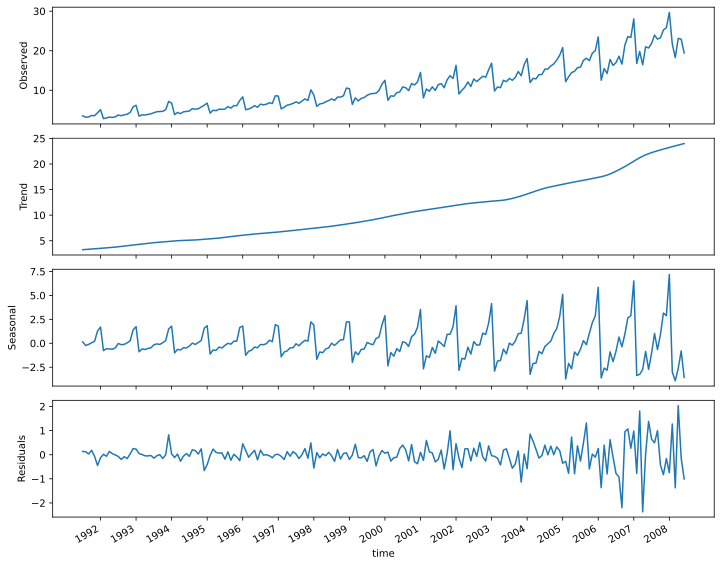

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows = 4, ncols = 1,
    sharex = True,
    figsize = (10, 8)
)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')


ax4.set_xlabel('time')

ax4.set_xticks(
    range(6, 205, 12),
    range(1992, 2009, 1),
)


fig.autofmt_xdate()
plt.tight_layout()

We can see a clear constant change over time, meaning we have a trend and the series will most likely not be stationary; in the next plot we can see that is has sesonality so will likely use a $SARIMA$ model for this guy

Let's start by making it stationary. I know it is obvious that is is not stationary but let's check that first and start differencing.

In [10]:
adf = sm.tsa.stattools.adfuller(df.y)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 3.145185689306747
p-value 1.0


In [11]:
diff = np.diff(df.y, n = 1)

In [12]:
adf = sm.tsa.stattools.adfuller(diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -2.4951721474496917
p-value 0.11665341686469954


After the first difference,  p-value is greater than 0.05, thus we cannot reject the null hypothesis, and the series remains not stationary. 

I want to make a quick parenthesis here. This also means that the series is not a random walk, since by definition "the first difference of the series must be stationary". Wanted to mention that out, were are not forecasting a random series.

Now we must do the sesonal differencing since we know it has based on the decomposition plots. We know that this data was recorded monthly meaning $m=12$ and we'll use that number to get the seasonal difference.

In [13]:
diff = np.diff(diff, n = 12)

In [14]:
adf = sm.tsa.stattools.adfuller(diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -19.84844009815286
p-value 0.0


Our adf statistic is a negative number and our p-value is 0, therefore we can now reject the null hypothesis and state that the series is stationary. Also we now know that $d = 1$ and $D = 1$. Let's make all possible combinations of $\{p,q,P,Q\}$ to select our model

In [15]:
p = range(0, 4)
q = range(0, 4)
ps = range(0, 4) # the s stands for seasonality
qs = range(0, 4)

d = 1
D = 1

m = 12

In [16]:
# get the 256 combinations, originally I started with 625, 
# but it was taking forever to run
combinations = list(itertools.product(p, q, ps, qs))

We'll use the last twelve months of the dataset as a the test set, then we'll compare our results with the acutal values as well as with the baseline (we still have not define it, do not worry)

In [17]:
train = df.y[:-12]
test = df.y[-12:]

In [18]:
import tqdm
def optimize_sarima(
        endog: pd.Series | list, combinations: list, 
        d: int, D: int, s:int) -> pd.DataFrame:

    '''
    Given a list of combinations of p,q,P,Q test different combinations of 
    SARIMA orders, and compare them against each other using
    Akaike Information  criterion.
  
    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param combinations list: list of all combinations of p, q, P, Q.
    :param d int: number of times the dataset needed to be diff to become 
                  stationary
    :param D int: number of times the dataset needed to be diff seasonably to 
                  become stationary
    :param s int: seasonal cycle aka frequency.
                

    :returns: dataframe with two columns, one the combination of p,q,P,Q
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in tqdm.tqdm_notebook(combinations):
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog, 
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

In [19]:
sarima_result = optimize_sarima(train, combinations, d, D, m)

  0%|          | 0/256 [00:00<?, ?it/s]

So it took 8 and a half mins to run with 256 combinations, originally I tried to use 625 combinations, but that meant being here like 40 min waiting on it to change.

In [20]:
sarima_result.head()

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 3)",410.593432
1,"(3, 2, 1, 3)",410.832665
2,"(3, 1, 1, 3)",411.970898
3,"(0, 3, 1, 3)",412.264113
4,"(2, 3, 2, 3)",412.356591


it seems that the best model is $SARIMA(2, 1, 3)(1, 1, 3)_{12}$, which makes me wonder... if we consider combinations with more numbers would it improve? Let's first try with this model and then we can try with diff numbers

In [21]:
model = sm.tsa.statespace.SARIMAX(
    train, 
    order = (2, 1, 3),
    seasonal_order = (1, 1, 3, 12),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

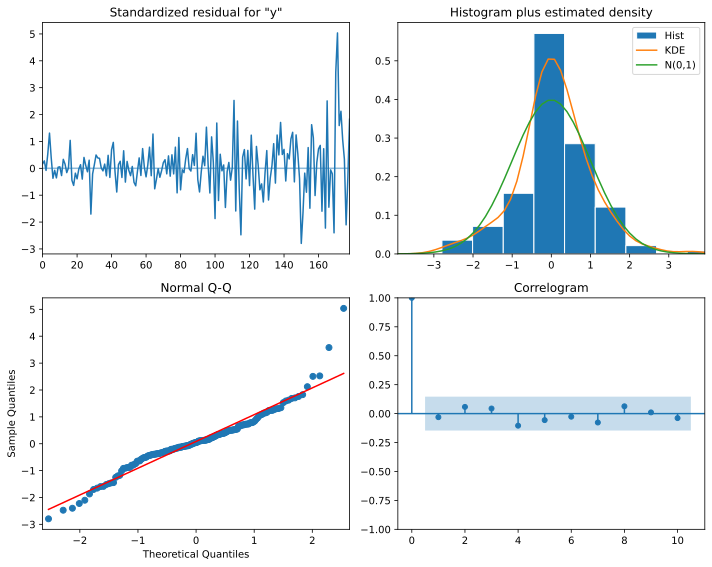

In [22]:
model.plot_diagnostics(figsize = (10, 8))
plt.tight_layout()

There is not trend in the residuals as seen in the top left plot; the Q-Q plot show us that the residuals behave like a normal distribution which is a good this.
They do not have correlation as per the botton left plot.

Let's get the Ljung-box statistic to see if they are correlated

In [23]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,0.598086,0.439309
2,0.753722,0.686011
3,1.322464,0.723806
4,3.500985,0.477729
5,3.519164,0.620490
6,3.519311,0.741399
7,7.858520,0.345235
8,8.657031,0.372049
9,8.682991,0.467036
10,9.326722,0.501403


There is no value smaller than 0,05 meaning we cannot reject the null hypothesis showing we the lags are not correlated

It seems that we have found the model, let's use it to make the predictions then.

In [41]:
sarima_pred = model.get_prediction(192, 203).predicted_mean
sarima_pred

192    21.013956
193    22.368574
194    20.624237
195    25.137230
196    25.793926
197    26.786923
198    30.589384
199    19.684980
200    22.337529
201    19.875687
202    24.032421
203    23.155487
Name: predicted_mean, dtype: float64

In [42]:
test = pd.DataFrame()
test['actual'] = df.y[-12:]
test['sarima_pred'] = sarima_pred
# the naive is using the values of the last year
test['naive_seasonal'] = df.y.iloc[179:191].values

In [43]:
test

,actual,sarima_pred,naive_seasonal
192,21.834890,21.013956,16.291602
193,23.930204,22.368574,16.980282
194,22.930357,20.624237,18.612189
195,23.263340,25.137230,16.623343
196,25.250030,25.793926,21.430241
197,25.806090,26.786923,23.575517
198,29.665356,30.589384,23.334206
199,21.654285,19.684980,28.038383
200,18.264945,22.337529,16.763869
201,23.107677,19.875687,19.792754


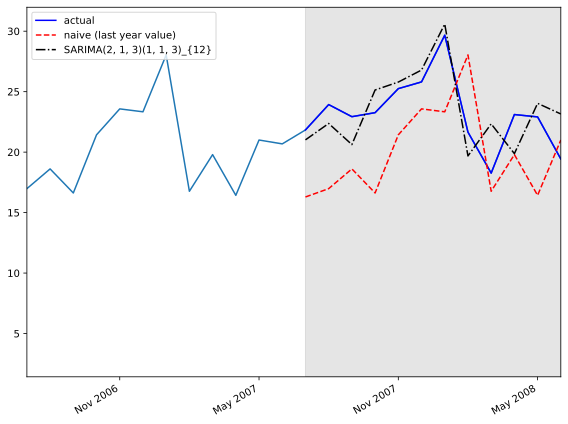

In [44]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(df.y)
ax.plot(test.actual, 'b', label = 'actual')
ax.plot(test.naive_seasonal, 'r--', label = 'naive (last year value)')
ax.plot(test.sarima_pred, 'k-.', label = 'SARIMA(2, 1, 3)(1, 1, 3)_{12}')

ax.legend(loc = 2)
ax.axvspan(192, 203, color='#808080', alpha = 0.2)

ax.set_xticks(
    [184, 190, 196, 202],
    ['Nov 2006', 'May 2007', 'Nov 2007', 'May 2008'],
)
ax.set_xlim(180, 203)

fig.autofmt_xdate()
plt.tight_layout()

It looks pretty good, and far better than our baseline model, let's quantify it with MAPE.

In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
mape_naive_seasonal = mape(test.actual, test.naive_seasonal)
mape_sarima = mape(test.actual, test.sarima_pred)

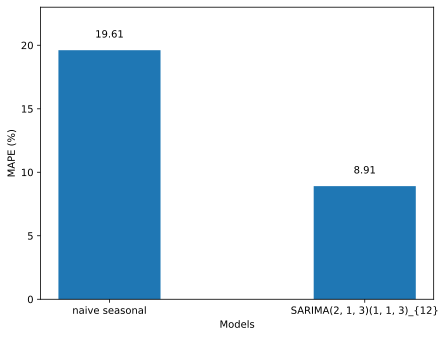

In [50]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2, 1, 3)(1, 1, 3)_{12}']
y = [mape_naive_seasonal, mape_sarima]


ax.bar(x, y, width = 0.4)

ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 23)

for index, value in enumerate(y):
    plt.text(
        x = index, y = value + 1, s = str(round(value,2)), ha = 'center'
    )
    
plt.tight_layout()

We can see that we can get by far better results than if we just used the values from last year. This means that if we use SARIMA we will be off on average by 8,91%.